In [1]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"

/media/paulati/Nuevo vol/paula/dh/2021/dsad_2021_paula/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


---

<img src='../../../common/logo_DH.png' align='left' width=35%/>


# Data Wrangling

## Introducción

Data wrangling es el proceso de limpieza y unificación de conjuntos de datos desordenados y complejos para facilitar su acceso, exploración, análisis o modelización posterior.

Las tareas que involucra son
* Limpieza de datos
* Eliminación de registros duplicados
* Transformación de datos
* Discretización de variables
* Detección y filtro de outliers
* Construcción de variables dummies


## Dataset

En esta clase usaremos un dataset con info de películas que disponibiliza datos de movielens (https://movielens.org/).

https://grouplens.org/datasets/movielens/

http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

Este conjunto de datos está conformado por varios archivos:
* **movies**: idPelicula, título y género; 

donde cada registro tiene los datos de una película

* **ratings**: idUsuario, idPelicula, rating, fecha; 

donde cada registro tienen la calificación otorgada por un usuario a una película

* **tags**: idUsuario, idPelicula, tag, fecha; 

donde cada registro tienen el tag que asignó un usuario a una película


## Imports

In [2]:
import pandas as pd
import numpy as np

## Ejercicio 1  - Importar 

Leamos los datos de movies, ratings y tags desde los archivos
* ../Data/movies.csv
* ../Data/ratings.csv
* ../Data/tags.csv

en las variables 
* data_movies
* data_ratings
* data_tags

Veamos cuántos registros hay en cada DataFrame y de qué tipos son los datos de cada columna. 

Veamos los primeros registros de cada DataFrame para verificar que los datos fueron importados correctamente.

In [3]:
data_ratings = pd.read_csv("../Data/ratings.csv", sep=",")
print(data_ratings.dtypes)
data_ratings.head(3)

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [4]:
data_tags = pd.read_csv("../Data/tags.csv", sep=",")
print(data_tags.dtypes)
data_tags.head(3)

userId        int64
movieId       int64
tag          object
timestamp     int64
dtype: object


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


In [5]:
data_movies = pd.read_csv("../Data/movies.csv", sep=",")
print(data_movies.dtypes)
data_movies.head(3)

movieId     int64
title      object
genres     object
dtype: object


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


## Ejercicio 2  - Registros duplicados

**2.a** Veamos si existen registros duplicados en el DataFrame data_tags considerando sólo las columnas "movieId", "tag", marcando como no duplicado la primera ocurrencia de un valor.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html


**2.b** Usemos el método `drop_duplicates` para obtener otro  `DataFrame` sin los casos duplicados considerando sólo las columnas "movieId", "tag". Usemos el método `duplicated` para verificar que el nuevo `DataFrame` efectivamente no tiene valores duplicados.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html

In [6]:
duplicated_mask = data_tags.duplicated(subset = [ "movieId", "tag"], keep = "first")

print(type(duplicated_mask))

print(any(duplicated_mask))

duplicated_records = data_tags.loc[duplicated_mask]
duplicated_records.sort_values(by=["movieId", "tag"]).head(10)


<class 'pandas.core.series.Series'>
True


,userId,movieId,tag,timestamp
981,474,1,pixar,1137206825
1001,474,32,time travel,1137206826
2494,477,32,time travel,1242494304
1034,474,153,superhero,1137375453
416,112,260,EPIC,1442535666
719,424,260,Star Wars,1457900775
417,119,260,classic,1435942530
531,193,260,classic sci-fi,1435856940
716,424,260,classic sci-fi,1457900772
552,205,260,sci-fi,1519899078


In [7]:
data_tags_nodup = data_tags.drop_duplicates(subset = ["movieId", "tag"], keep = "first")
print(data_tags.shape)
print(data_tags_nodup.shape)

dup_mask = data_tags_nodup.duplicated(subset = ["movieId", "tag"], keep = "first")
any(dup_mask)

(3683, 4)
(3579, 4)


False

## Ejercicio 3 - Transformar datos

Construyamos un diccionario que asocie un puntaje a una etiqueta.

Las etiquetas son:

* mala, para puntajes menores a 3;

* regular, para mayor igual a 3 y  menor que 4;

* buena para puntaje mayor o igual que 4

Usemos el método `map` para crear una nueva columna en data (`rating_label`) que tenga las etiquetas asociadas al valor del campo `rating` para cada registro


In [8]:
np.sort(data_ratings.rating.unique())

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [9]:
etiquetas = { 0.5: "mala",
             1:  "mala",
             1.5:  "mala",
             2:  "mala",
             2.5:  "mala",
             3: "regular",
             3.5: "regular",
             4: "buena",
             4.5: "buena",
             5: "buena"    
}

In [10]:
data_ratings["rating_label"] = data_ratings.rating.map(etiquetas)
data_ratings.head(3)

,userId,movieId,rating,timestamp,rating_label
0,1,1,4.0,964982703,buena
1,1,3,4.0,964981247,buena
2,1,6,4.0,964982224,buena


Nota: esto ya sabíamos resolverlo usando máscaras booleanas

## Ejercicio 4 - Reemplazar valores

El método `replace` ofrece varias formas de efectuar reemplazos sobre una serie de Pandas:

* Un valor viejo por un valor nuevo.
    
* Una lista de valores viejos por un valor nuevo.
    
* Una lista de valores viejos por una lista de valores nuevos.
    
* Un diccionario que mapee valores nuevos y viejos.


https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html

**4.a - Una lista de valores viejos por un valor nuevo** 

Veamos cuáles son los tags que están asignados a una única película. 

Reemplacemos ese valor por "tag_que_no_funciona" y eliminemos registros duplicados considerando los campos "userId",  "movieId", "tag".

Ayuda: `value_counts`

In [11]:
tag_counts = data_tags.tag.value_counts()
tag_counts_1_mask = tag_counts == 1
tags_counts_1 = tag_counts.loc[tag_counts_1_mask]
print(len(tag_counts))
print(len(tags_counts_1))
tags_counts_1

1589
1038


action choreography                1
out of order                       1
post apocalyptic                   1
video games                        1
Captain America                    1
                                  ..
Michigan                           1
Oscar (Best Supporting Actress)    1
hip hop                            1
chilly                             1
"artsy"                            1
Name: tag, Length: 1038, dtype: int64

In [12]:
data_tags_frecuentes =  data_tags.replace(tags_counts_1.index, "tag_que_no_funciona")
data_tags_frecuentes

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,tag_que_no_funciona,1445715207
4,2,89774,tag_que_no_funciona,1445715200
...,...,...,...,...
3678,606,7382,tag_que_no_funciona,1171234019
3679,606,7936,tag_que_no_funciona,1173392334
3680,610,3265,tag_que_no_funciona,1493843984
3681,610,3265,tag_que_no_funciona,1493843978


In [13]:
data_tags_frecuentes_nodup = data_tags_frecuentes.drop_duplicates(subset = ["userId", "movieId", "tag"], keep = "first")
print(data_tags_frecuentes_nodup.shape)
print(data_tags_frecuentes.shape)

(3254, 4)
(3683, 4)


**4.b - Una lista de valores viejos por una lista de valores nuevos**

Reemplacemos cada valor de tag, por la primera palabra que lo compone.

Para eso, creamos una serie con valores únicos con el valor del campo tag. 

Contruimos otra instancia de Series donde cada elemento sea la primera palabra del objeto Series anterior. Ayuda: listas por comprensión y `split`

Usamos replace para campiar el valor de cada tag por su primera palabra.


In [14]:
tags_unique = data_tags.tag.unique()
#print(tags_unique)
print(len(tags_unique))
tags_primera_palabra = [x.split()[0] for x in tags_unique]
#print(tags_primera_palabra)
print(len(tags_primera_palabra))

1589
1589


In [15]:
data_tags_resumen = data_tags.replace(tags_unique, tags_primera_palabra)
print(data_tags.head(10))
print(data_tags_resumen.head(10))

   userId  movieId                tag   timestamp
0       2    60756              funny  1445714994
1       2    60756    Highly quotable  1445714996
2       2    60756       will ferrell  1445714992
3       2    89774       Boxing story  1445715207
4       2    89774                MMA  1445715200
5       2    89774          Tom Hardy  1445715205
6       2   106782              drugs  1445715054
7       2   106782  Leonardo DiCaprio  1445715051
8       2   106782    Martin Scorsese  1445715056
9       7    48516       way too long  1169687325
   userId  movieId       tag   timestamp
0       2    60756     funny  1445714994
1       2    60756    Highly  1445714996
2       2    60756      will  1445714992
3       2    89774    Boxing  1445715207
4       2    89774       MMA  1445715200
5       2    89774       Tom  1445715205
6       2   106782     drugs  1445715054
7       2   106782  Leonardo  1445715051
8       2   106782    Martin  1445715056
9       7    48516       way  1169687325

**4.c - Un diccionario que mapee valores nuevos y viejos**

Reemplacemos los valores de tags 
* "Al Pacino" por "Pacino"
* "Leonardo DiCaprio" por "DiCaprio"
* "Tom Hanks" por "Hanks"
* "Martin Scorsese" por "Scorsese"

Contemos cuantas veces aparecen cada uno de los valores a reemplazar, y cuántas los valores de reemplazo. Ayuda: `value_counts`

Construyamos un diccionario con este mapeo y usemos el método `replace`

Volvamos a contar cuántas veces aparecen cada uno de los valores a reemplazar, y cuántas los valores de reemplazo.


In [16]:
tag_counts = data_tags.tag.value_counts()
print(tag_counts["Al Pacino"])
print(tag_counts["Leonardo DiCaprio"])
print(tag_counts["Tom Hanks"])
print(tag_counts["Martin Scorsese"])

5
10
4
4


In [17]:
print("Pacino" in tag_counts.keys())
print("DiCaprio" in tag_counts.keys())
print("Hanks" in tag_counts.keys())
print("Scorsese" in tag_counts.keys())


False
False
False
False


In [18]:
replacement = {
    "Al Pacino": "Pacino", 
    "Leonardo DiCaprio": "DiCaprio",
    "Tom Hanks": "Hanks",
    "Martin Scorsese": "Scorsese"
}

data_tags_dict_replacement = data_tags.replace(replacement)

In [19]:
tag_counts_replacement = data_tags_dict_replacement.tag.value_counts()
print(tag_counts_replacement["Pacino"])
print(tag_counts_replacement["DiCaprio"])
print(tag_counts_replacement["Hanks"])
print(tag_counts_replacement["Scorsese"])

5
10
4
4


In [20]:
print("Al Pacino" in tag_counts_replacement.keys())
print("Leonardo DiCaprio" in tag_counts_replacement.keys())
print("Tom Hanks" in tag_counts_replacement.keys())
print("Martin Scorsese" in tag_counts_replacement.keys())


False
False
False
False


## Ejercicio 5 - Discretizar variables

Vamos a volver a resolver el Ejercicio 3 usando el método `cut`

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

Defino los valores de corte:

* mala, para puntajes menores a 3;

* regular, para mayor igual a 3 y  menor que 4;

* buena para puntaje mayor o igual que 4


In [21]:
# valores de corte:
bins_rating = [0, 3, 4, 5.1]
labels_rating = ["mala", "regular", "buena"]

# Obtengo una lista de intervalos
# right=False indice que el extremo derecho del intervalo no está incluído en la categoría
categories = pd.cut(data_ratings.rating, bins_rating, labels = labels_rating, right=False)

data_ratings["rating_label_cut"] = categories
data_ratings.head(10)

,userId,movieId,rating,timestamp,rating_label,rating_label_cut
0,1,1,4.0,964982703,buena,buena
1,1,3,4.0,964981247,buena,buena
2,1,6,4.0,964982224,buena,buena
3,1,47,5.0,964983815,buena,buena
4,1,50,5.0,964982931,buena,buena
5,1,70,3.0,964982400,regular,regular
6,1,101,5.0,964980868,buena,buena
7,1,110,4.0,964982176,buena,buena
8,1,151,5.0,964984041,buena,buena
9,1,157,5.0,964984100,buena,buena


## Ejercicio 6 - Detectar y filtrar outliers

No existe un criterio que sea válido en todos los casos para identificar los outliers. El criterio de mayor que el tercer cuartil más 1.5 veces el rango intercuartil o menor que el primer cuartil menos 1.5 veces el rango intercuartil (Q3 - Q1) surge de la distribución normal. En esa distribución el 99.7% de la población se encuentra en el rango definido por la media (poblacional) más menos 3 veces el desvío estándar (poblacional)

**Queremos ver cuáles son las películas que son outliers en cantidad de calificaciones.**

**6.a** Usando data_ratings eliminamos duplicados considerando las columnas "userId", "movieId". Esto lo hacemos para contar sólo una vez los votos de un usuario a una película.

**6.b** Sobre el DataFrame obtenido en el paso anterior, hacemos count agrupado por película. Esto nos da como resultado una instancia de Series que asignamos a la variable movie_votes_count.

**6.c** Calculemos los cuartilos de los valores de movie_votes_count y los valores que usaremos de umbral para determinar outliers.
(Ayuda: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.quantile.html)

**6.d** Filtremos los datos de movie_votes_count excluyendo los outliers. 

**6.e** Comparemos movie_votes_count antes y después del filtro con:
* el método `describe`
* boxplots de seaborn

**6.f** Adicional: Miremos cuáles son los títulos de las cinco películas más votadas que son outliers de cantidad de calificaciones

In [22]:
#6.a

data_ratings_nodup = data_ratings.drop_duplicates(subset = ["userId", "movieId"], keep = "first")

#6.b
movie_votes_count = data_ratings_nodup.groupby("movieId")["userId"].count()

#6.c
q1 = movie_votes_count.quantile(0.25)
print(q1)
q2 = movie_votes_count.quantile(0.5)
print(q2)
q3 = movie_votes_count.quantile(0.75)
print(q3)


iqr = (q3 - q1) * 1.5

up_threshold = q3 + iqr
low_threshold = q1 - iqr

print(up_threshold)
print(low_threshold)

#6.d
outlier_mask_up = movie_votes_count > up_threshold
outlier_mask_down = movie_votes_count < low_threshold
outlier_mask = np.logical_or(outlier_mask_up, outlier_mask_down)
not_outliers = np.logical_not(outlier_mask)

outliers = movie_votes_count[outlier_mask]

1.0
3.0
9.0
21.0
-11.0


In [23]:
#6.e
movie_votes_count_filtered = movie_votes_count[not_outliers]
movie_votes_count_filtered.describe()

count    8545.000000
mean        4.137390
std         4.568132
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        21.000000
Name: userId, dtype: float64

In [24]:
movie_votes_count.describe()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: userId, dtype: float64

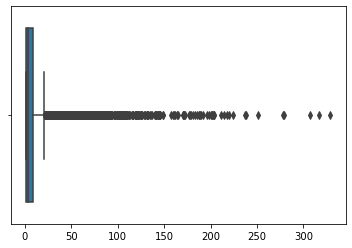

In [25]:
import seaborn as sns
sns.boxplot(x=movie_votes_count.values);

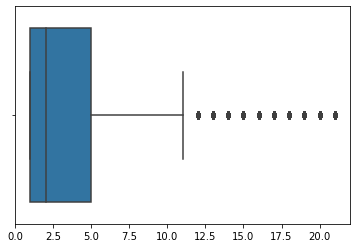

In [26]:
sns.boxplot(x=movie_votes_count_filtered.values);

In [27]:
#6.f

outliers_sort = np.sort(outliers.values)[::-1]
print("cantidad de votos ordenados de mayor a menor: ", outliers_sort)

top_5 = outliers_sort[0:5]
print("cantidad de votos máximos: ", top_5)

top_5_outliers_mask = outliers.apply(lambda x: x in top_5)
top_5_outliers_movieId = outliers.loc[top_5_outliers_mask].index
print("ids de las peliculas en el top 5 de votos", top_5_outliers_movieId)

top_5_movieId_mask = data_movies.movieId.apply(lambda x: x in top_5_outliers_movieId)
data_movies.loc[top_5_movieId_mask, "title"]


cantidad de votos ordenados de mayor a menor:  [329 317 307 ...  22  22  22]
cantidad de votos máximos:  [329 317 307 279 278]
ids de las peliculas en el top 5 de votos Int64Index([296, 318, 356, 593, 2571], dtype='int64', name='movieId')


257                  Pulp Fiction (1994)
277     Shawshank Redemption, The (1994)
314                  Forrest Gump (1994)
510     Silence of the Lambs, The (1991)
1939                  Matrix, The (1999)
Name: title, dtype: object

## Ejercicio 7 - Variables categóricas y dummies

**7.a** Usando el método `get_dummies` con `drop_first = True` agreguemos al DataFrame data_ratings variables dummies que representen las categorias de rating_label

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html


**7.b** Comparemos las variables dummies generadas en el punto anterior con las que se generan usando `drop_first = False`. ¿Cuál es la diferencia? ¿Representan el mismo conjunto de valores posibles?

**7.c** Adicional: Cambienos las categorias que se muestran como resultado de `get_dummies` con `drop_first = True`. Ayuda: https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html#categoricaldtype



In [28]:
# 7.a

dummies_rating_label = pd.get_dummies(data_ratings.rating_label, prefix='rating_label', drop_first=True)

# agregamos las columnas dummies
data_ratings_with_dummy = data_ratings.join(dummies_rating_label)

# quitamos la columna rating_label que ahora queda representada por las dummies
result = data_ratings_with_dummy.drop(labels = ["rating_label"], axis="columns")
result.head(5)

,userId,movieId,rating,timestamp,rating_label_cut,rating_label_mala,rating_label_regular
0,1,1,4.0,964982703,buena,0,0
1,1,3,4.0,964981247,buena,0,0
2,1,6,4.0,964982224,buena,0,0
3,1,47,5.0,964983815,buena,0,0
4,1,50,5.0,964982931,buena,0,0


In [29]:
# 7.b

dummies_rating_label = pd.get_dummies(data_ratings.rating_label, prefix='rating_label', drop_first=False)
dummies_rating_label

,rating_label_buena,rating_label_mala,rating_label_regular
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
100831,1,0,0
100832,1,0,0
100833,1,0,0
100834,1,0,0


En esta segunda solución (7.b), tenemos una columna para cada categoría de los valores originales. 

Los valores representados son exactamente los mismos que había en la columna original (como en las solución 7.a), pero una de las columnas es redundante porque se puede determinar su valor partiendo de los valores de las otras dos.

Las dos soluciones representan todas la categorias posibles de la variable original. 

Observemos que los valores (0,0,0), (0,1,1), (1,1,0), (1,0,1), (1,1) no representan una categoría en la variable original.

In [30]:
# 7.c

from pandas.api.types import CategoricalDtype
    
cat_type = CategoricalDtype(categories=["mala", "regular", "buena"], ordered=True)

labels_cat = data_ratings.rating_label.astype(cat_type)

pd.get_dummies(labels_cat, prefix='rating_label', drop_first=True)

,rating_label_regular,rating_label_buena
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
100831,0,1
100832,0,1
100833,0,1
100834,0,1
